Q.1. Use the taxi trip dataset to find clusters of locations that might belong to a particular cluster having similar kinds of trip features. Use DBSCAN algo for this.
Show the locations belonging to each cluster over a map.
Perform the analysis of trips belonging to the same clusters and point out the distinguishing features and insights.
Also, divide a day in 1-hour slot and show a time of day based analysis of each cluster

Note: To map the ZoneId(Pickup and Dropoff) to their spatial coordinates, use the Zone Lookup table from the link below. This will be used to create visualization of clusters on the map.

Dataset link: https://drive.google.com/file/d/1L97I_30HY-Q4BKujiPWPODjkvPo2Vnlm/view?usp=drive_link

Zone Lookup table:
https://drive.google.com/file/d/1tIVIoCyGKRaVsxN_KOS3T5O-SIZPrvqp/view?usp=sharing

Refer to the document for working with PARQUET format.
You can find more information about the dataset at: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path="/content/drive/MyDrive/yellow_tripdata_2023-01.parquet"

In [ ]:
path="/content/drive/MyDrive/ZoneLookup.csv"

In [ ]:
import pandas as pd
import pyarrow as pa
df = pd.read_parquet('/content/drive/MyDrive/yellow_tripdata_2023-01.parquet')
print(df.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:32:10   2023-01-01 00:40:36              1.0   
1         2  2023-01-01 00:55:08   2023-01-01 01:01:27              1.0   
2         2  2023-01-01 00:25:04   2023-01-01 00:37:49              1.0   
3         1  2023-01-01 00:03:48   2023-01-01 00:13:25              0.0   
4         2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.97         1.0                  N           161           141   
1           1.10         1.0                  N            43           237   
2           2.51         1.0                  N            48           238   
3           1.90         1.0                  N           138             7   
4           1.43         1.0                  N           107            79   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


**INSIGHT:** Here we can see how the dataset looks.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pyarrow.parquet import ParquetFile
import pyarrow as pa

# Load the dataset
taxi_df = pd.read_parquet('/content/drive/MyDrive/yellow_tripdata_2023-01.parquet')

pf = ParquetFile('/content/drive/MyDrive/yellow_tripdata_2023-01.parquet')
first_one_lakh_rows = next(pf.iter_batches(batch_size = 100000))
df = pa.Table.from_batches([first_one_lakh_rows]).to_pandas()
print(df.head())




   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:32:10   2023-01-01 00:40:36              1.0   
1         2  2023-01-01 00:55:08   2023-01-01 01:01:27              1.0   
2         2  2023-01-01 00:25:04   2023-01-01 00:37:49              1.0   
3         1  2023-01-01 00:03:48   2023-01-01 00:13:25              0.0   
4         2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.97         1.0                  N           161           141   
1           1.10         1.0                  N            43           237   
2           2.51         1.0                  N            48           238   
3           1.90         1.0                  N           138             7   
4           1.43         1.0                  N           107            79   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


In [ ]:
from pyarrow.parquet import ParquetFile
import pyarrow as pa

pf = ParquetFile('/content/drive/MyDrive/yellow_tripdata_2023-01.parquet')
first_one_lakh_rows = next(pf.iter_batches(batch_size = 100000))
df = pa.Table.from_batches([first_one_lakh_rows]).to_pandas()
print(df.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:32:10   2023-01-01 00:40:36              1.0   
1         2  2023-01-01 00:55:08   2023-01-01 01:01:27              1.0   
2         2  2023-01-01 00:25:04   2023-01-01 00:37:49              1.0   
3         1  2023-01-01 00:03:48   2023-01-01 00:13:25              0.0   
4         2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.97         1.0                  N           161           141   
1           1.10         1.0                  N            43           237   
2           2.51         1.0                  N            48           238   
3           1.90         1.0                  N           138             7   
4           1.43         1.0                  N           107            79   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


**Insight:** It is to read first 100,000 rows from the Parquet file using PyArrow. It fetches the data in batches, converts it into a pandas DataFrame, and displays the first few rows. This  efficiently handles large datasets while allowing easy integration with pandas for analysis.

In [ ]:
print(df.shape)

(100000, 19)


In [ ]:
# Load the Zone Lookup table
zone_lookup_df = pd.read_csv('/content/drive/MyDrive/ZoneLookup.csv')

# Merge the dataset with the Zone Lookup table
# merged_df = pd.merge(taxi_df, zone_lookup_df, left_on=['PULocationID', 'DOLocationID'], right_on=['LocationID', 'LocationID'], how='left')
#merged_df = pd.merge(taxi_df, zone_lookup_df, left_on=['PULocationID', 'DOLocationID'], right_on=['PickupLocationID', 'DropoffLocationID'], how='left')
#merged_df = pd.merge(taxi_df, zone_lookup_df, left_on=['PULocationID', 'DOLocationID'], right_on=['Pickup_Location_ID', 'Dropoff_Location_ID'], how='left')
merged_df = pd.concat([df,zone_lookup_df], axis=1)



In [ ]:
print(merged_df.shape)
merged_df.head()

(100000, 22)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,ZoneId,Latitude,Longitude
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.5,0.00,0.0,1.0,14.30,2.5,0.00,1.0,191376.7495,9.359968e+05
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,0.5,4.00,0.0,1.0,16.90,2.5,0.00,2.0,164018.7544,1.031086e+06
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,0.5,15.00,0.0,1.0,34.90,2.5,0.00,3.0,254265.4787,1.026453e+06
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,0.5,0.00,0.0,1.0,20.85,0.0,1.25,4.0,202959.7824,9.906340e+05
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,0.5,3.28,0.0,1.0,19.68,2.5,0.00,5.0,140681.3514,9.318714e+05


**Insight:** The merged DataFrame allows for the analysis of taxi trip data in conjunction with geographic zone information. It enables exploration of factors like trip duration, distance traveled, fares, and geographic patterns, which could be valuable for various analysis such as demand forecasting, route optimization, or understanding customer behaviour.

(array([ 1394.,  7057.,  7366.,  4101., 13187., 16975., 14399.,  4770.,
        18066., 12685.]),
 array([  1. ,  27.4,  53.8,  80.2, 106.6, 133. , 159.4, 185.8, 212.2,
        238.6, 265. ]),
 <BarContainer object of 10 artists>)

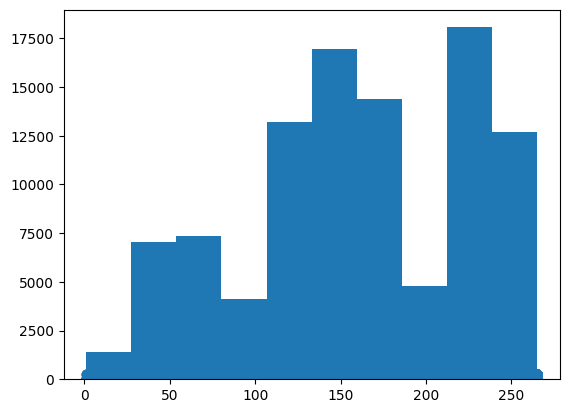

In [ ]:
plt.scatter( merged_df['PULocationID'],merged_df['DOLocationID'])
plt.hist(merged_df['PULocationID'])

**Insight:** The histogram reveals the distribution of pickup locations. Peaks in the histogram represent locations with high pickup frequencies, while valleys indicate less popular pickup spots. Understanding the distribution can inform decisions related to resource allocation, such as assigning more taxis to areas with high demand or identifying areas for potential business expansion.

(array([ 4132.,  8546.,  8255.,  4703.,  7577., 16117., 12629.,  4154.,
        19830., 14057.]),
 array([  1. ,  27.4,  53.8,  80.2, 106.6, 133. , 159.4, 185.8, 212.2,
        238.6, 265. ]),
 <BarContainer object of 10 artists>)

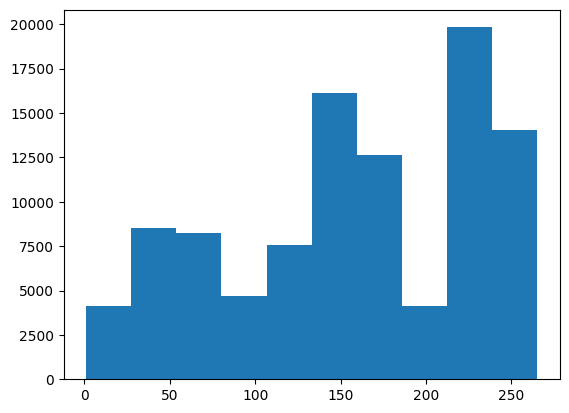

In [ ]:
plt.hist(merged_df['DOLocationID'])

**Insight:** Travel in city ode from 140 to 180 and 220 to 250 is comparetively high.

(array([25554.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 74446.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

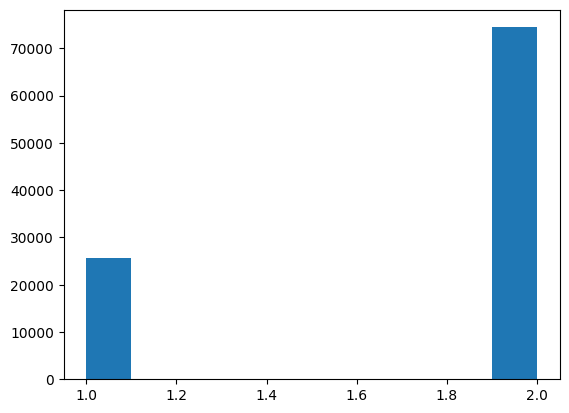

In [ ]:
plt.hist(merged_df['VendorID'])

**Insight:** Market occupied by vendor 2 is comparetively high

In [ ]:
# # Preprocess the data for clustering
# # Assuming 'Latitude' and 'Longitude' are the columns for spatial coordinates
# merged_df['Pickup_Coordinates'] = list(zip(merged_df['pickup_longitude'], merged_df['pickup_latitude']))
# merged_df['Dropoff_Coordinates'] = list(zip(merged_df['dropoff_longitude'], merged_df['dropoff_latitude']))

# Apply DBSCAN
#scaler = StandardScaler()
#X = scaler.fit_transform(merged_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
x=merged_df.iloc[:,[4,14]]
x.head()





,trip_distance,tolls_amount
0,0.97,0.0
1,1.10,0.0
2,2.51,0.0
3,1.90,0.0
4,1.43,0.0


In [ ]:
dbscan=DBSCAN(eps=0.275,min_samples=30)
dbscan.fit(x)
label = dbscan.labels_
label

print(label.shape)
print(merged_df.shape)
# merged_df.head()


(100000,)
(100000, 22)


**Insight:** DBSCAN clustering is done.

In [ ]:
from sklearn import metrics

#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)

sample_cores[dbscan.core_sample_indices_]=True

#Calculating the number of clusters

n_clusters=len(set(label))- (1 if -1 in label else 0)
print('No of clusters:',n_clusters)

No of clusters: 5


In [ ]:
merged_df['cluster']=label
print(merged_df['cluster'].unique())

[ 0 -1  1  3  2  4]


(array([46347., 23962.,  8711.,  4584.,  3890.]),
 array([ 0.,  2.,  4.,  6.,  8., 10.]),
 <BarContainer object of 5 artists>)

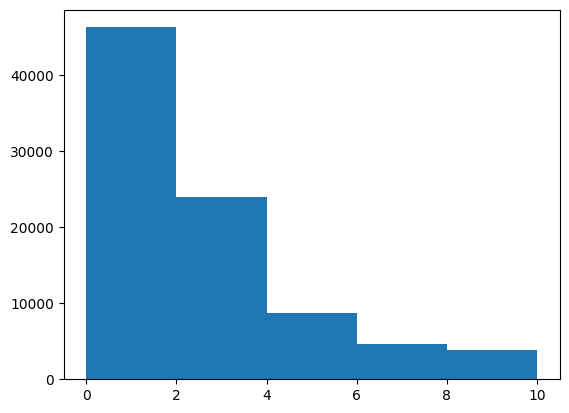

In [ ]:
plt.hist(merged_df['trip_distance'],bins=5,range = (0, 10))

**Insight:** The histogram indicates that a significant number of trips have short distances, as evidenced by the peak in the first bin. This suggests that a large portion of taxi trips in the dataset cover short distances, likely within city limits or nearby areas.

In [ ]:
merged_df['cluster']=label
c1=merged_df[merged_df['cluster']==0]
c2=merged_df[merged_df['cluster']==1]
c3=merged_df[merged_df['cluster']==2]
c4=merged_df[merged_df['cluster']==3]
c5=merged_df[merged_df['cluster']==4]
c6=merged_df[merged_df['cluster']==-1]

In [ ]:
print(len(c1))
print(len(c2))
print(len(c3))
print(len(c4))
print(len(c5))
print(len(c6))


89235
8929
142
41
30
1623


**Insight:** Most data points belong to Cluster 0, suggesting it's the most prevalent cluster, while Clusters 2, 3, and 4 contain significantly fewer data points. Additionally, there's a cluster labeled as outliers (Cluster -1), containing a notable number of data points.

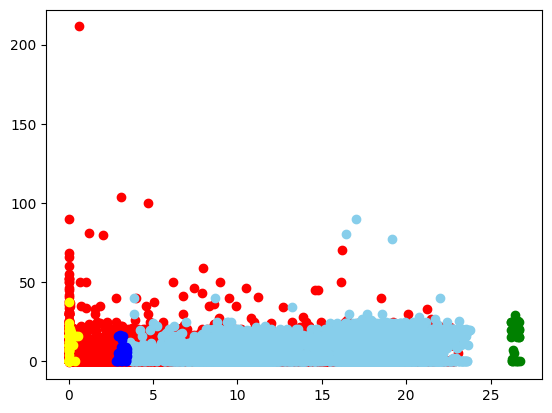

In [ ]:
plt.scatter(c1['trip_distance'],c1['tip_amount'],color='red')
plt.scatter(c2['trip_distance'],c2['tip_amount'],color='skyblue')
plt.scatter(c3['trip_distance'],c3['tip_amount'],color='yellow')
plt.scatter(c4['trip_distance'],c4['tip_amount'],color='blue')
plt.scatter(c5['trip_distance'],c5['tip_amount'],color='green')
#plt.scatter(c6['trip_distance'],c6['tip_amount'],color='orange')
plt.show()

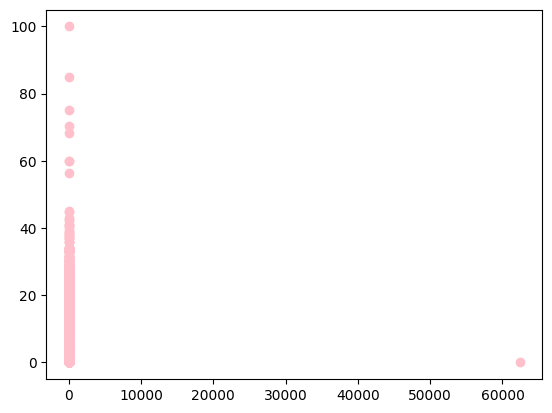

In [ ]:
plt.scatter(c6['trip_distance'],c6['tip_amount'],color='pink')
plt.show()

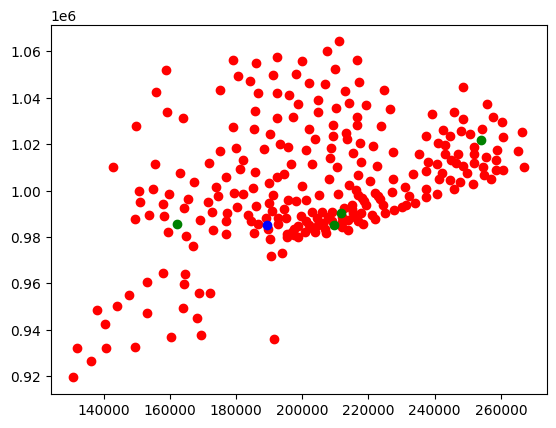

In [ ]:
plt.scatter(c1['Latitude'],c1['Longitude'],color='red')
plt.scatter(c2['Latitude'],c2['Longitude'],color='green')
plt.scatter(c3['Latitude'],c3['Longitude'],color='purple')
plt.scatter(c4['Latitude'],c4['Longitude'],color='blue')
plt.scatter(c5['Latitude'],c5['Longitude'],color='yellow')
#plt.scatter(c6['trip_distance'],c6['tip_amount'],color='orange')
plt.show()

**Insight:**          
Trip Distance vs. Tip Amount:

Different clusters exhibit varying distributions of trip distance and tip amount, with some clusters showing more concentrated patterns than others.
Cluster 0 tends to have a diverse spread of trip distances and tip amounts, while other clusters may be more concentrated.

Latitude vs. Longitude:

Clusters are depicted geographically, showing their spatial distribution across different regions.
Each cluster represent specific geographic areas or patterns, with some clusters covering wider regions than others.

In [ ]:
!pip install geopandas
!pip install descartes

In [ ]:
path="/content/drive/MyDrive/taxi_zones.shx"
path="/content/drive/MyDrive/taxi_zones.dbf"
path="/content/drive/MyDrive/taxi_zones.prj"
path="/content/drive/MyDrive/taxi_zones.sbn"
path="/content/drive/MyDrive/taxi_zones.sbx"
path="/content/drive/MyDrive/taxi_zones.shp"
path="/content/drive/MyDrive/taxi_zones.shp.xml"

In [ ]:
import geopandas as gpd

import matplotlib.pyplot as plt
df2 = '/content/drive/MyDrive/taxi_zones.shp'
# Read the shapefile for New York map
ny_map = gpd.read_file(df2)


In [ ]:
# Create a GeoDataFrame for each cluster
c1_geo = gpd.GeoDataFrame(c1, geometry=gpd.points_from_xy(c1['Longitude'], c1['Latitude']))
c2_geo = gpd.GeoDataFrame(c2, geometry=gpd.points_from_xy(c2['Longitude'], c2['Latitude']))
c3_geo = gpd.GeoDataFrame(c3, geometry=gpd.points_from_xy(c3['Longitude'], c3['Latitude']))
c4_geo = gpd.GeoDataFrame(c4, geometry=gpd.points_from_xy(c4['Longitude'], c4['Latitude']))
c5_geo = gpd.GeoDataFrame(c5, geometry=gpd.points_from_xy(c5['Longitude'], c5['Latitude']))
c6_geo = gpd.GeoDataFrame(c6, geometry=gpd.points_from_xy(c6['Longitude'], c6['Latitude']))


<Axes: >

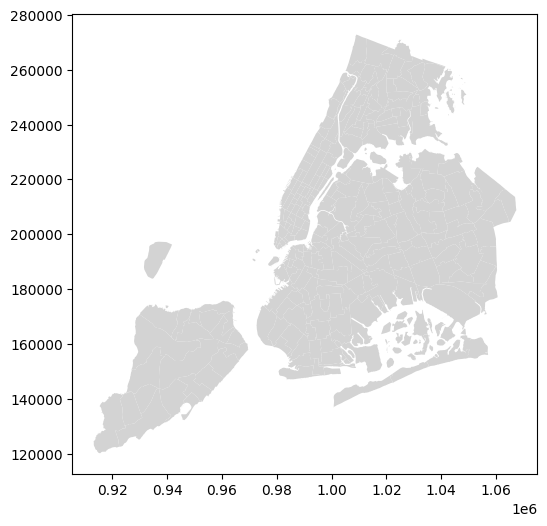

In [ ]:
# Plot the New York map
fig, ax = plt.subplots(figsize=(6, 6))
ny_map.plot(ax=ax, color='lightgray')

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:417: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:417: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  warnings.warn(


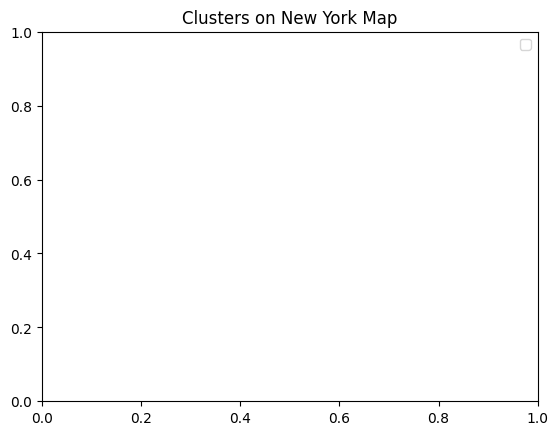

In [ ]:
import matplotlib.pyplot as plt
# Plot each cluster on the map
c1_geo.plot(ax=ax, markersize=10, color='green', label='cluster 0')
c2_geo.plot(ax=ax, markersize=10, color='blue', label='cluster 1')
c3_geo.plot(ax=ax, markersize=10, color='red', label='cluster 2')
c4_geo.plot(ax=ax, markersize=10, color='orange', label='cluster 3')
c5_geo.plot(ax=ax, markersize=10, color='purple', label='cluster 4')
c6_geo.plot(ax=ax, markersize=10, color='yellow', label='cluster -1')

# Set the title and legend
plt.title('Clusters on New York Map')
plt.legend()

# Show the plot
plt.show()

